In [28]:
import os
import json
import shutil
import tarfile
import requests
import warnings

import scipy.io
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.io import read_image
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchvision.transforms import Resize
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchvision.transforms import Compose

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
warnings.filterwarnings("ignore")
plt.style.use("custom.mplstyle")

## Download Dataset

The data needed for training are:

- Dataset images (filename: `102flowers.tgz`)
- Image Labels (filename: `imagelabels.mat`)
- Label Map (filename: `label_map.json`)

Since the dataset images are compressed as a tarball, we need to extract these into a folder. Besides extraction, the code does a few other things:

- It extracts the tarball into a directory called `images/`.
- Since the images are nested inside a subdirectory called `jpg/`, it moves these images to the root output directory (`images/`).
- It then deletes the empty subdirectory.
- Since the images are named as `image_0XXXX.jpg` which is verbose, it renames images as `XXXX.jpg`.
- Since the first image is named `1.jpg`, it renames each image to one less than its current number.

This allows for direct correspondence between image filenames and the label indices.

In [3]:
def download_dataset():
  base_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/"
  images_path = "102flowers.tgz"
  labels_path = "imagelabels.mat"

  if not os.path.exists(images_path):
    print("Downloading dataset images ...")
    response = requests.get(base_url + images_path, stream=True)
    with open(images_path, "wb") as f:
      f.write(response.content)

  if not os.path.exists(labels_path):
    print("Downloading image labels ...")
    response = requests.get(base_url + labels_path, stream=True)
    with open(labels_path, "wb") as f:
      f.write(response.content)

In [4]:
def extract_images():
  output_dir = "images"
  if os.path.exists(output_dir):
    return
  
  archive_path = "102flowers.tgz"
  os.makedirs(output_dir, exist_ok=True)

  with tarfile.open(archive_path, "r:gz") as tar:
    tar.extractall(path=output_dir)

  subdir = os.path.join(output_dir, "jpg")

  for image_file in os.listdir(subdir):
    image_path = os.path.join(subdir, image_file)

    if os.path.isfile(image_path):
      shutil.move(image_path, output_dir)

  os.rmdir(subdir)

  image_files = sorted([f for f in os.listdir(output_dir) if f.startswith("image_") and f.endswith(".jpg")])

  for idx, filename in enumerate(image_files):
    old_path = os.path.join(output_dir, filename)
    new_filename = f"{idx}.jpg"
    new_path = os.path.join(output_dir, new_filename)

    os.rename(old_path, new_path)

In [5]:
download_dataset()
extract_images()

with open("label_map.json", "r") as f:
  label_map = json.load(f)
  label_map = {int(k): v for k, v in label_map.items()}

## Dataset Class

We subclass PyTorch `Dataset` and implement the three required methods: `__init__()`, `__len__()`, and `__getitem__()`. Also, because we use pretrained weights for ImageNetV2, our images should be preprocessed in a similar way to what was used to train the model with ImageNetV2. The transformation we used is composed of these steps:

- Pad the image to a square.
- Convert the image to a tensor.
- Resize the image to size $224 \times 224$.
- Normalize the image with mean: $(0.485, 0.456, 0.406)$ and standard deviation: $(0.229, 0.224, 0.225)$.

The labels are provided as MAT-file, so we load the MAT-file using `scipy.io` module, and extract the 8189-element array provided as the `labels` column.

To make sure everything works as expected, we can view a random image and label pair from this flower dataset. Unfortunately, we are not able to observe the normalization effect, since matplotlib's `imshow()` expects the image to be in the range $(0, 1)$ or $(0, 255)$, while normalization will introduce negative pixel values. Therefore, we have to denormalize the image before plotting the image.

In [6]:
class FlowerDataset(Dataset):
  def __init__(self, annotations_file, img_dir):
    self.img_labels = self.load_annotations(annotations_file)
    self.img_dir = img_dir

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, f"{idx}.jpg")
    image = read_image(img_path)
    image = self.transform(image)
    label = self.img_labels[idx]
    return image, label

  def transform(self, image):
    image_np = image.permute(1, 2, 0).numpy()
    aug = iaa.PadToSquare()
    image = aug(image=image_np)

    preprocess = Compose([
      ToTensor(),
      Resize(224),
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = preprocess(image)
    return image

  def load_annotations(self, annotations_file):
    mat_data = scipy.io.loadmat(annotations_file)
    return np.squeeze(mat_data["labels"])

In [17]:
flowerdataset = FlowerDataset(annotations_file="imagelabels.mat", img_dir="images")

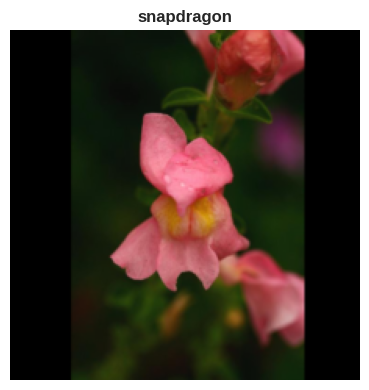

In [8]:
def denormalize(tensor, mean, std):
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return tensor

figure = plt.figure(figsize=(4, 4))
img, label = flowerdataset[torch.randint(0, len(flowerdataset), (1,)).item()]

denorm_img = denormalize(img.clone(), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = denorm_img.permute(1, 2, 0).numpy()
img = np.clip(img, 0, 1)

plt.imshow(img)
plt.title(label_map[label])
plt.axis("off")
plt.show()

## Train-Validation-Test Split

We split the dataset randomly such that the training set is $50\%$, validation set is $30\%$, and test set is $20\%$ of the full dataset. We also fix the generator for reproducible results.

In [15]:
generator = torch.Generator().manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(flowerdataset, [0.5, 0.3, 0.2], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Training

Since the challenge required to use ResNet50 with pretrained weights, we use just that. For the optimizer, we selected the Adam optimizer due to its robustness to bad hyperparameter initialization. For the loss function, we chose the cross-entropy loss since it works perfectly when training a classification problem with $C$ classes (in our case, $C = 102$).

In [ ]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

## Training Loop

We train for model for 20 epochs, since upon training, it can be noted that the model converges and achieves $>90\%$ accuracy very fast. During each epoch:

- We perform a forward pass given a batch of images.
- The model outputs raw scores called logits, which is an $(N \times 102)$-element tensor, where $N$ is the batch size.
- We then perform a backward pass to calculate the gradients.
- We then perform an optimization step which updates the model parameters.
- The logits are passed through a softmax function in order to produce probabilities for each class.
- The model predictions are calculated as the maximum value of the $102$ values in each logit.
- The training accuracy is calculated as the percentage of correct predictions out of all predictions.
- The validation accuracy is calculated as the percentage of correct predictions in a similar way but on the validation set.

Finally, we plot the training loss, training accuracy, and validation accuracy to observe the model's performance over time and ensure that it is not overfitting the training set.

In [10]:
def training_loop(model, criterion, optimizer, train_dataloader, valid_dataloader, n_epochs):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.train()

  train_losses = []
  train_accuracies = []
  valid_accuracies = []

  for epoch in range(n_epochs):
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0

    for i, (inputs, targets) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
      inputs = inputs.to(device)
      targets = targets.to(device)

      logits = model(inputs)
      loss = criterion(logits, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      probabilities = F.softmax(logits, dim=1)
      _, predictions = torch.max(probabilities, dim=1)
      train_total += targets.size(0)
      train_correct += (predictions == targets).sum().item()

    with torch.no_grad():
      for inputs, targets in valid_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)

        probabilities = F.softmax(logits, dim=1)
        _, predictions = torch.max(probabilities, dim=1)
        valid_total += targets.size(0)
        valid_correct += (predictions == targets).sum().item()

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = 100 * train_correct / train_total        
    epoch_val = 100 * valid_correct / valid_total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    valid_accuracies.append(epoch_val)

    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%, Validation Accuracy: {epoch_val:.2f}%")
  
  torch.save(model.state_dict(), "model-weights.pth")
  return train_losses, train_accuracies, valid_accuracies

In [11]:
train_losses, train_accuracies, valid_accuracies = training_loop(model, criterion, optimizer, train_dataloader, valid_dataloader, n_epochs=20)

100%|██████████| 77/77 [00:12<00:00,  5.99it/s]


Epoch [1/20], Loss: 2.2190, Training Accuracy: 51.75%, Validation Accuracy: 76.03%


100%|██████████| 77/77 [00:12<00:00,  6.10it/s]


Epoch [2/20], Loss: 0.4441, Training Accuracy: 87.45%, Validation Accuracy: 85.27%


100%|██████████| 77/77 [00:12<00:00,  6.11it/s]


Epoch [3/20], Loss: 0.1996, Training Accuracy: 94.31%, Validation Accuracy: 86.81%


100%|██████████| 77/77 [00:12<00:00,  5.96it/s]


Epoch [4/20], Loss: 0.1418, Training Accuracy: 96.19%, Validation Accuracy: 90.27%


100%|██████████| 77/77 [00:12<00:00,  6.09it/s]


Epoch [5/20], Loss: 0.1214, Training Accuracy: 96.17%, Validation Accuracy: 86.81%


100%|██████████| 77/77 [00:12<00:00,  6.05it/s]


Epoch [6/20], Loss: 0.0997, Training Accuracy: 97.48%, Validation Accuracy: 89.66%


100%|██████████| 77/77 [00:12<00:00,  6.06it/s]


Epoch [7/20], Loss: 0.1354, Training Accuracy: 95.95%, Validation Accuracy: 88.40%


100%|██████████| 77/77 [00:12<00:00,  6.09it/s]


Epoch [8/20], Loss: 0.0827, Training Accuracy: 97.88%, Validation Accuracy: 87.22%


100%|██████████| 77/77 [00:12<00:00,  5.99it/s]


Epoch [9/20], Loss: 0.0764, Training Accuracy: 97.88%, Validation Accuracy: 89.74%


100%|██████████| 77/77 [00:12<00:00,  6.09it/s]


Epoch [10/20], Loss: 0.0676, Training Accuracy: 98.12%, Validation Accuracy: 91.05%


100%|██████████| 77/77 [00:12<00:00,  6.08it/s]


Epoch [11/20], Loss: 0.0488, Training Accuracy: 98.75%, Validation Accuracy: 92.43%


100%|██████████| 77/77 [00:12<00:00,  6.03it/s]


Epoch [12/20], Loss: 0.0613, Training Accuracy: 98.39%, Validation Accuracy: 89.01%


100%|██████████| 77/77 [00:12<00:00,  6.12it/s]


Epoch [13/20], Loss: 0.0599, Training Accuracy: 98.39%, Validation Accuracy: 89.34%


100%|██████████| 77/77 [00:12<00:00,  6.15it/s]


Epoch [14/20], Loss: 0.0364, Training Accuracy: 99.02%, Validation Accuracy: 89.82%


100%|██████████| 77/77 [00:12<00:00,  6.21it/s]


Epoch [15/20], Loss: 0.0878, Training Accuracy: 97.39%, Validation Accuracy: 89.87%


100%|██████████| 77/77 [00:12<00:00,  6.13it/s]


Epoch [16/20], Loss: 0.0556, Training Accuracy: 98.53%, Validation Accuracy: 89.05%


100%|██████████| 77/77 [00:12<00:00,  6.08it/s]


Epoch [17/20], Loss: 0.0688, Training Accuracy: 98.10%, Validation Accuracy: 89.09%


100%|██████████| 77/77 [00:12<00:00,  6.07it/s]


Epoch [18/20], Loss: 0.0891, Training Accuracy: 97.70%, Validation Accuracy: 88.69%


100%|██████████| 77/77 [00:12<00:00,  5.99it/s]


Epoch [19/20], Loss: 0.0768, Training Accuracy: 97.92%, Validation Accuracy: 90.39%


100%|██████████| 77/77 [00:12<00:00,  6.10it/s]


Epoch [20/20], Loss: 0.0296, Training Accuracy: 99.02%, Validation Accuracy: 91.25%


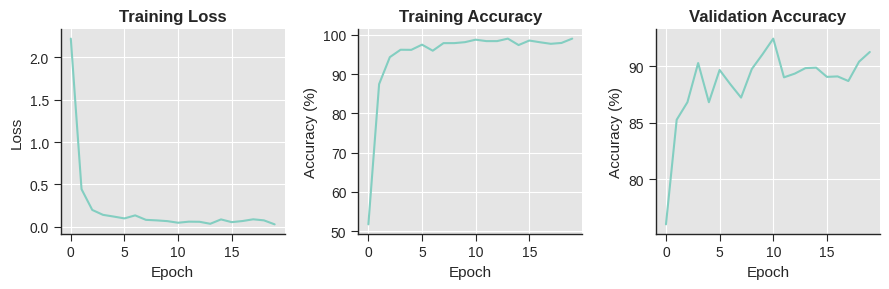

In [12]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 3, 1)
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")

plt.subplot(1, 3, 2)
plt.plot(train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")

plt.subplot(1, 3, 3)
plt.plot(valid_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")

plt.tight_layout()
plt.show()

## Model Evaluation

Although the dataset is well-balanced, we still want to ensure that accuracy score is not misleading. We therefore evaluate the model on three metrics: precision, recall, and accuracy. We achieve a reasonably high precision, recall, and accuracy scores, which shows that the model converged successfully and did not overfit the training set much. On our test run, we noted the following scores:

- Precision: $0.9155$
- Recall:    $0.9074$
- Accuracy:  $91.14\%$

In [42]:
def evaluate(model, test_dataloader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()

  y_true = np.empty(0)
  y_pred = np.empty(0)

  torch.cuda.empty_cache()

  with torch.no_grad():
    for inputs, targets in tqdm(test_dataloader, total=len(test_dataloader)):
      inputs = inputs.to(device)
      targets = targets.to(device)
      
      logits = model(inputs)
      probabilities = F.softmax(logits, dim=1)
      _, predictions = torch.max(probabilities, dim=1)

      y_pred = np.append(y_pred, predictions.cpu().numpy())
      y_true = np.append(y_true, targets.cpu().numpy())

  precision = precision_score(y_true, y_pred, average="macro")
  recall = recall_score(y_true, y_pred, average="macro")
  accuracy = accuracy_score(y_true, y_pred)

  return precision, recall, accuracy


In [44]:
model = resnet50()
model.load_state_dict(torch.load("model-weights.pth", weights_only=True))

precision, recall, accuracy = evaluate(model, test_dataloader)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"Accuracy:  {accuracy*100:.2f}%")

100%|██████████| 52/52 [00:08<00:00,  6.45it/s]


Precision: 0.9155
Recall:    0.9074
Accuracy:  91.14%
